In [1]:
import torch
from transformers import AutoModel,AutoConfig,AutoTokenizer,AutoModelForSequenceClassification,Trainer,TrainingArguments,DataCollatorWithPadding
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict
import evaluate
import re

/usr/local/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%%time
# 加载数据
excel_file = './10w.xlsx'
data_frame = pd.read_excel(excel_file)

CPU times: user 23.1 s, sys: 257 ms, total: 23.3 s
Wall time: 23.3 s


In [3]:
# # 随机抽样（预实验使用）
# data_frame = data_frame.sample(n=3000)
# data_frame

,接触ID,用户号码,来电时间,服务请求,转写文本
86500,2023011616380836944263S1,18566801318,2023-01-16 16:38:10,服务请求>>咨询>>宽带业务>>宽带资费政策,client:您好很高兴为您服务 client:你好 user:我我现在要重置一下我那个 u...
77168,2023011110560218145448S1,15502032632,2023-01-11 10:56:06,服务请求>>查询>>业务信息>>查询停机原因,client:您好很高兴为您服务 user:喂你好 client:喂你好 client:你好...
55505,2023011111035138743352S1,18566111138,2023-01-11 11:03:55,服务请求>>查询>>业务信息>>合约查询,client:你好实习员工为您服务您好 user:喂你好我这个手机号码里面有一个什么合约到4...
29165,2023011214525852244980S1,13076897945,2023-01-12 14:53:02,服务请求>>查询>>查话费>>流量包查询,"client:啊您好很高兴为您服务 user:嗯喂你好麻烦你帮我查一下我嗯,我办了一个就是,..."
15911,2023011111342149145898S1,16624633057,2023-01-11 11:37:08,服务请求>>查询>>业务信息>>套餐资费,client:您好很高兴服务 user:哎你好我想问一下我这个卡的话是在全国通用吗还是有限地...
...,...,...,...,...,...
86387,2023011117361664347633S1,13286471850,2023-01-11 17:44:21,服务请求>>办理>>增值/权益>>在信业务取消,client:您好很高兴为您服务 user:喂你好 client:嗯你好 user:刚才你们...
67827,2023011108104638647541S1,18664916189,2023-01-11 08:10:51,服务请求>>咨询>>业务规则>>销户/退网（含预约拆机）,"client:您好很高兴为您服务 user:喂你好,请问我这个,查3个月,那不用的话不充话费..."
59050,2023011109334183045131S1,75000422443,2023-01-11 09:37:35,服务请求>>办理>>宽带业务>>家庭网络检测,client:您好很高兴为您服务 client:宽带故障是吧 user:喂你好我想报一下故障...
82129,2023011220173875744472S1,13226455603,2023-01-12 20:17:44,服务请求>>无效来话>>来电断线>>来电断线,user:喂你好我的那个这个上个月的那个费用怎么扣了那么多啊 client:上个月对吧 cl...


In [4]:
# 停用词预处理
stop_words = ['您好','你好',':很高兴为您服务','请问有什么可以帮您','client','user',' ']
sep_words = ['。', '!', '?', ',']
def ProcessStopWords(text):
    for word in stop_words:
        text = text.replace(word,'')
    text = text.replace(':','[SEP]').replace('[SEP]','',1) # 删除第一个[SEP]
    for word in sep_words:
        text = text.replace(word, '[SEP]')
    return text

data_frame['转写文本'] = data_frame['转写文本'].map(ProcessStopWords)

In [5]:
data_frame['转写文本'].iloc[0]

'[SEP]我我现在要重置一下我那个[SEP]宽带那个路由器然后现在登录进去之后有一个用户账户是不是你们发过来那1串[SEP]呃[SEP]字母跟文字啊[SEP]用户的账户是吗[SEP]对啊他用户账户跟上网账号是一个吗[SEP]对[SEP]那用户密码呢我都忘记了哦[SEP]用户密码的话这个是您自行设置的[SEP]那现在[SEP]我换了路由器之后忘记密码了用户密码了怎么弄啊[SEP]啊您可以登陆那个用那个路由器嘛它不是可以登陆那个首页登录账号账号吗您点那个忘记密码然后重新设置一下[SEP]啊[SEP]没有他这里没有忘记密码这个选项哦[SEP]没有忘记密码这个选项是吗[SEP]他就有一个用户账户还有一个用户密码然后下面就有一个登陆一个重置[SEP]一个登陆一个重置[SEP]重置那个你有没有点过[SEP]没有[SEP]你点一下重置就是重置重新设置一下[SEP]没有啊[SEP]点不到重置吗[SEP]重置他就[SEP]把那用户账户没了[SEP]账户没了[SEP]对啊就是把那个用户账户那个[SEP]那那个账号消除的他没有一个[SEP]重新设置哦[SEP]这边的话您是更换更换了光猫吗[SEP]没有更换一个路由器[SEP]是之前路由器坏了吗[SEP]请稍等一下啊[SEP]然后另外给您看的话您现在宽带那边[SEP]有出现那个集中性的一个故障[SEP]什么故障[SEP]集中性的一个故障[SEP]不太明白[SEP]就是区域的故障[SEP]区域故障是什么意思啊[SEP]区域故障就是现在宽带是可能网络的话没办法上网[SEP]没事我现在先登录先修改好路由器[SEP]路由器的账号他1般都是您这个宽带的账号密码的话都是您自己设置的我给您看一下有没有有没有重置的密码[SEP]我现在是插入那个光猫然后它里面这个中国联通这个[SEP]这个他有一个pom啊闪老是闪烁哦[SEP]就是区域故障的一个信号吗[SEP]那上网密码呢[SEP]密码的话我给您看查询一下看看是不是有有没有显示哈[SEP]宽带密码的话1般他都是初始的就1到6[SEP]我看一下[SEP]看行不行[SEP]呃不正确[SEP]不正确[SEP]您宽带的账号您登录的是哪个账号[SEP]他就是刚才问了你们这个他发短信过来的宽带上网账号是[SEP]Fsftw[SEP]Th77901串数字的[SEP]后面尾号是不是一个艾特然后16900[SEP]对对对.g

In [6]:
# 标签预处理
regex = re.compile(r'^.*?>(.*?)>.*?$')
def ProcessLabels(text):
    text = text.replace('>>','>').replace('10019','')
    text = re.match(regex, text).groups()[0]
    return text

data_frame['服务请求'] = data_frame['服务请求'].map(ProcessLabels)

In [7]:
# 预览预处理结果
data_frame['转写文本'].iloc[:10]

86500    [SEP]我我现在要重置一下我那个[SEP]宽带那个路由器然后现在登录进去之后有一个用户账户...
77168    喂[SEP]喂[SEP][SEP]哎请问一下我现在这个号码是属于一个什么状态我这个[SEP]...
55505    实习员工为您服务[SEP]喂我这个手机号码里面有一个什么合约到4月份才到期的[SEP][SE...
29165    啊很高兴为您服务[SEP]嗯喂麻烦你帮我查一下我嗯[SEP]我办了一个就是[SEP]流量包就...
15911    很高兴服务[SEP]哎我想问一下我这个卡的话是在全国通用吗还是有限地区吗[SEP]嗯好稍等一...
31069    我[SEP]为什么我的[SEP]呃刚才的话电话打不通然后说呃说要呃实名[SEP]二次[SEP...
69095    就是我前2天开通的那个25元那个20gb那个流量[SEP]我用了一个1天的我后边这个找不到了...
99360    我那个我今天充了一百五十块钱我现在还欠费吗[SEP]稍等一下我帮您看一下[SEP]嗯[SEP...
91729    喂[SEP]没有我问一下多少钱一个月[SEP]你这个号码一个月的话是39块一个月的[SEP]...
23932    啊我的手机打不了电话是怎么回事[SEP]请稍等帮您看一下哈[SEP]这边看到的话是需要您再次...
Name: 转写文本, dtype: object

In [8]:
# 训练复盘并分析数据集后，考虑在前面的处理把 样本数<1000 的剔除，即剔除下列：
rm_labels = ['临时','其他','商机','资料信息','业务变更问题','投诉','故障']
for rm_label in rm_labels:
    data_frame.drop(data_frame[data_frame.服务请求 == rm_label].index, inplace=True)
data_frame

,接触ID,用户号码,来电时间,服务请求,转写文本
86500,2023011616380836944263S1,18566801318,2023-01-16 16:38:10,咨询,[SEP]我我现在要重置一下我那个[SEP]宽带那个路由器然后现在登录进去之后有一个用户账户...
77168,2023011110560218145448S1,15502032632,2023-01-11 10:56:06,查询,喂[SEP]喂[SEP][SEP]哎请问一下我现在这个号码是属于一个什么状态我这个[SEP]...
55505,2023011111035138743352S1,18566111138,2023-01-11 11:03:55,查询,实习员工为您服务[SEP]喂我这个手机号码里面有一个什么合约到4月份才到期的[SEP][SE...
29165,2023011214525852244980S1,13076897945,2023-01-12 14:53:02,查询,啊很高兴为您服务[SEP]嗯喂麻烦你帮我查一下我嗯[SEP]我办了一个就是[SEP]流量包就...
15911,2023011111342149145898S1,16624633057,2023-01-11 11:37:08,查询,很高兴服务[SEP]哎我想问一下我这个卡的话是在全国通用吗还是有限地区吗[SEP]嗯好稍等一...
...,...,...,...,...,...
86387,2023011117361664347633S1,13286471850,2023-01-11 17:44:21,办理,喂[SEP]嗯[SEP]刚才你们联通客服打电话给我叫我办啥[SEP]不知道办的啥不知道办的啥...
67827,2023011108104638647541S1,18664916189,2023-01-11 08:10:51,咨询,喂[SEP]请问我这个[SEP]查3个月[SEP]那不用的话不充话费他自动会冻结吗[SEP]...
59050,2023011109334183045131S1,75000422443,2023-01-11 09:37:35,办理,宽带故障是吧[SEP]喂我想报一下故障[SEP]就是[SEP]嗯对[SEP]好您的宽带有跟本...
82129,2023011220173875744472S1,13226455603,2023-01-12 20:17:44,无效来话,喂我的那个这个上个月的那个费用怎么扣了那么多啊[SEP]上个月对吧[SEP]上个月流量超了5...


In [9]:
prompts = np.array(data_frame['转写文本'])
choices = np.array(data_frame['服务请求'])

In [10]:
data_frame['服务请求']

86500      咨询
77168      查询
55505      查询
29165      查询
15911      查询
         ... 
86387      办理
67827      咨询
59050      办理
82129    无效来话
49211      咨询
Name: 服务请求, Length: 2995, dtype: object

In [11]:
# 取最大长度
data_frame.insert(data_frame.shape[1], 'text_len',None)
data_frame['text_len'] = data_frame['转写文本'].map(len)
max_length_index = data_frame['text_len'].argmax()
max_length = data_frame['text_len'].iloc[max_length_index]
max_length_index, max_length

(0, 2075)

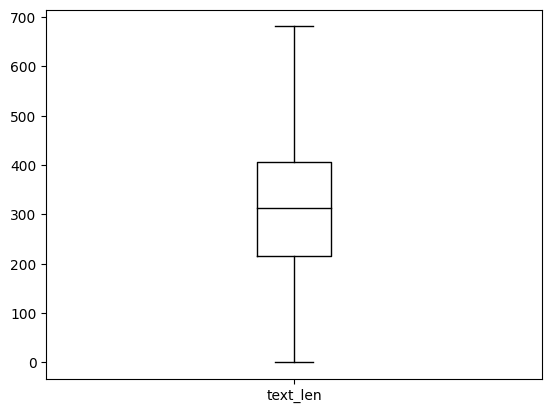

In [12]:
# 观察文本长度分布（排除异常值）
data_frame.boxplot('text_len', grid=False, showfliers=False, color='Black')
plt.suptitle("")
plt.xlabel("")
plt.show()
# 由图可知，取512足够覆盖正常样本
max_length = 512

In [13]:
# 去重choices，并保存原choices对应去重后的位置
unique_choices = np.unique(choices)
labels = np.array([np.argwhere(unique_choices==v)[0]  for v in choices])
unique_choices.shape, labels.shape

((5,), (2995, 1))

In [14]:
# 加入标签
data_frame.insert(0, 'label', value=labels)
data_frame[:10]

,label,接触ID,用户号码,来电时间,服务请求,转写文本,text_len
86500,2,2023011616380836944263S1,18566801318,2023-01-16 16:38:10,咨询,[SEP]我我现在要重置一下我那个[SEP]宽带那个路由器然后现在登录进去之后有一个用户账户...,2075
77168,4,2023011110560218145448S1,15502032632,2023-01-11 10:56:06,查询,喂[SEP]喂[SEP][SEP]哎请问一下我现在这个号码是属于一个什么状态我这个[SEP]...,215
55505,4,2023011111035138743352S1,18566111138,2023-01-11 11:03:55,查询,实习员工为您服务[SEP]喂我这个手机号码里面有一个什么合约到4月份才到期的[SEP][SE...,355
29165,4,2023011214525852244980S1,13076897945,2023-01-12 14:53:02,查询,啊很高兴为您服务[SEP]嗯喂麻烦你帮我查一下我嗯[SEP]我办了一个就是[SEP]流量包就...,476
15911,4,2023011111342149145898S1,16624633057,2023-01-11 11:37:08,查询,很高兴服务[SEP]哎我想问一下我这个卡的话是在全国通用吗还是有限地区吗[SEP]嗯好稍等一...,250
31069,3,2023011320130096444237S1,13018458313,2023-01-13 20:13:04,无效来话,我[SEP]为什么我的[SEP]呃刚才的话电话打不通然后说呃说要呃实名[SEP]二次[SEP...,197
69095,0,2023011116535957944418S1,18688405572,2023-01-11 16:54:03,不满,就是我前2天开通的那个25元那个20gb那个流量[SEP]我用了一个1天的我后边这个找不到了...,395
99360,3,2023011118492412943316S1,16676282823,2023-01-11 18:49:30,无效来话,我那个我今天充了一百五十块钱我现在还欠费吗[SEP]稍等一下我帮您看一下[SEP]嗯[SEP...,292
91729,3,2023011609584277347809S1,13078677669,2023-01-16 09:58:44,无效来话,喂[SEP]没有我问一下多少钱一个月[SEP]你这个号码一个月的话是39块一个月的[SEP]...,405
23932,0,2023011412273517945530S1,13168845920,2023-01-14 12:27:36,不满,啊我的手机打不了电话是怎么回事[SEP]请稍等帮您看一下哈[SEP]这边看到的话是需要您再次...,199


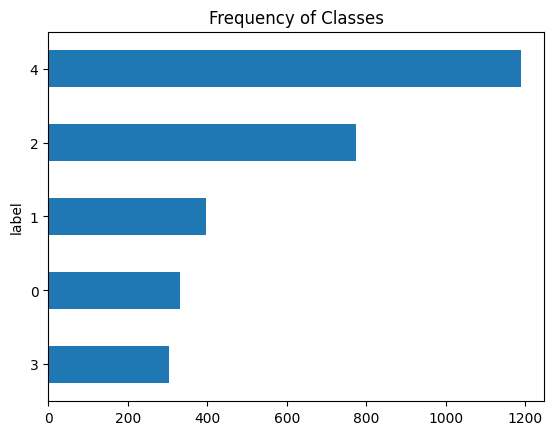

In [15]:
# 取出特征与labels
df = data_frame[['label', '转写文本', '服务请求']]
df[:10]
# 统计
df['label'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [16]:
# # 手动处理样本非均衡情况
# df4 = df[df['label'] == 4].sample(n=30000)
# df2 = df[df['label'] == 2]
# df1 = pd.DataFrame(np.repeat(df[df['label'] == 1].values, 2, axis=0), columns=df.columns)
# df0 = pd.DataFrame(np.repeat(df[df['label'] == 0].values, 2, axis=0), columns=df.columns)
# df3 = pd.DataFrame(np.repeat(df[df['label'] == 3].values, 2, axis=0), columns=df.columns)

# df = pd.concat([df0, df1, df2, df3, df4], ignore_index=True)

In [17]:
# 先排序 label，以便后续充分打乱
df = df.sort_values(by='服务请求')

In [18]:
df

,label,转写文本,服务请求
48502,0,请问有什么可以帮到您你查一下我这个号码的那个光猫光信号是不是没网了[SEP]本机来电是吗[S...,不满
91554,0,先生[SEP]那我帮我看一下我的手机为什么上不了网呢[SEP]您稍等一下先生[SEP]就是没...,不满
11149,0,嗯对[SEP]呃为什么我本机号码收不到那个短信呢验证码短信[SEP]短信呢是哪一个软件收不到...,不满
22592,0,啊我要查询一下我本机啊上个月用了多少的费用[SEP]上个月是吗[SEP]是啊[SEP]好稍等...,不满
65565,0,我[SEP]大家好[SEP]您说[SEP]为什么我那个电话上不了网呢是没流量还是怎么样[SE...,不满
...,...,...,...
390,4,啊就是我想问一下我现在手机一个月月租是多少钱的[SEP]我帮您看一下嗯就是167块嘛然后里面...,查询
34525,4,李先生呃我想麻烦你帮我查询一下我这张卡的月租是多少钱一个月[SEP]我看一下您稍等[SEP]...,查询
15029,4,哎我那个副卡怎么不可以打电话呢打不通[SEP]不卡打不了电话是吧[SEP]老是暂停服务呢[S...,查询
68262,4,嗯[SEP]那[SEP]啊嗯[SEP]是那个畅享铂金会员是吗[SEP]比较优惠建议法律[SE...,查询


In [19]:
# 创建数据集
ds = DatasetDict({'train': Dataset.from_pandas(df)})
# ds['train'] = ds['train'].rename_column('转写文本','text')
ds = ds.remove_columns(['服务请求'])

ds['train'] = ds['train'].rename_columns({'转写文本':'text'})
ds = ds['train'].train_test_split(0.2, shuffle=True) # 按 8:2 分割数据集
ds, ds['train'][0], ds['test'][0]

(DatasetDict({
     train: Dataset({
         features: ['label', 'text', '__index_level_0__'],
         num_rows: 2396
     })
     test: Dataset({
         features: ['label', 'text', '__index_level_0__'],
         num_rows: 599
     })
 }),
 {'label': 0,
  'text': '哎你帮我查一个我十月十二月份的账单有一个上网费12块钱是什么东西[SEP]嗯[SEP]那就是您超出套餐外的流量费用啊[SEP]怎么会你们这个流量套餐不是无限的吗[SEP]啊不是您套餐的话只有40g的流量的700分钟通话超出按3块钱1g嘛[SEP]1局3块钱[SEP]嗯对[SEP]我不是无限的啦现在[SEP]呃不是',
  '__index_level_0__': 33309},
 {'label': 4,
  'text': '啊我这边就是在那个联通app选了一个副卡[SEP]呃它显示是19块钱一个月3g流量加100分钟我想问一下就是这个打完之后是不是可以用我主卡上面的那个通话时间和流量呢[SEP]稍等一下[SEP]你是用哪个号码下的单[SEP]还没下[SEP]这个我现在在准备办理[SEP]不卡[SEP]然后副卡的话里面是没有流量的他是按照套主卡套餐内容啊[SEP]哦这样子啊[SEP]对是按照主卡内容的[SEP]就是全部都是用我主卡的钱是吧[SEP]对用主卡的[SEP]刚刚可能点错了点了个办理主卡[SEP]嗯那[SEP]副卡的号码怎么选不到呢[SEP]副卡的话在app搜索副卡副卡的话或者亲情卡[SEP]就是副卡跟主卡打电话之间收不收费嘞[SEP]免费[SEP]呃就外省或者是省内都可以是吧[SEP]对国内[SEP]国内啊好的好的行我明白了[SEP]嗯那还谁帮到你呢[SEP]没有[SEP]嗯好那这边的话就不打扰您了稍后听到语音的话麻烦先生帮忙评价一下2个1谢谢您啊再见',
  '__index_level_0__': 27324})

In [20]:
%%time
model_path = './chinese-electra-base-discriminator'
tokenizer = AutoTokenizer.from_pretrained(model_path)
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=max_length)

tokenized_ds = ds.map(preprocess_function, batched=True)

Map: 100%|██████████| 599/599 [00:00<00:00, 3211.03 examples/s]

CPU times: user 3.62 s, sys: 71.7 ms, total: 3.7 s
Wall time: 1.02 s


In [21]:
# 模型
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # 允许不同长度tensor的存在
model_config = AutoConfig.from_pretrained(model_path)
model_config.num_labels = unique_choices.shape[0]
model = AutoModelForSequenceClassification.from_config(model_config)

In [22]:
tokenized_ds['train'][0]

{'label': 0,
 'text': '哎你帮我查一个我十月十二月份的账单有一个上网费12块钱是什么东西[SEP]嗯[SEP]那就是您超出套餐外的流量费用啊[SEP]怎么会你们这个流量套餐不是无限的吗[SEP]啊不是您套餐的话只有40g的流量的700分钟通话超出按3块钱1g嘛[SEP]1局3块钱[SEP]嗯对[SEP]我不是无限的啦现在[SEP]呃不是',
 '__index_level_0__': 33309,
 'input_ids': [101,
  1511,
  872,
  2376,
  2769,
  3389,
  671,
  702,
  2769,
  1282,
  3299,
  1282,
  753,
  3299,
  819,
  4638,
  6572,
  1296,
  3300,
  671,
  702,
  677,
  5381,
  6589,
  8110,
  1779,
  7178,
  3221,
  784,
  720,
  691,
  6205,
  102,
  1638,
  102,
  6929,
  2218,
  3221,
  2644,
  6631,
  1139,
  1947,
  7623,
  1912,
  4638,
  3837,
  7030,
  6589,
  4500,
  1557,
  102,
  2582,
  720,
  833,
  872,
  812,
  6821,
  702,
  3837,
  7030,
  1947,
  7623,
  679,
  3221,
  3187,
  7361,
  4638,
  1408,
  102,
  1557,
  679,
  3221,
  2644,
  1947,
  7623,
  4638,
  6413,
  1372,
  3300,
  8164,
  8181,
  4638,
  3837,
  7030,
  4638,
  8389,
  1146,
  7164,
  6858,
  6413,
  6631,
  1139,
  2902,
  124,
  1779,
  7178,
  10719,
  1658,
  102,
  122,


In [23]:
# 评估
accuracy = evaluate.load('./evaluate/metrics/accuracy/accuracy.py')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [24]:
# Adam 训练阶段
training_args = TrainingArguments('./output',evaluation_strategy='epoch',save_strategy='epoch', learning_rate=5e-7, 
                                    load_best_model_at_end=True, num_train_epochs=3)
trainer = Trainer(model, args=training_args, train_dataset=tokenized_ds['train'], eval_dataset=tokenized_ds['test'], 
                  tokenizer=tokenizer, data_collator=data_collator, compute_metrics=compute_metrics)

In [25]:
%%time
# 训练
trainer.train(resume_from_checkpoint=False)

You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.410110,0.425710
2,1.482200,1.409117,0.425710


CPU times: user 2min 1s, sys: 2.54 s, total: 2min 3s
Wall time: 2min 3s


TrainOutput(global_step=600, training_loss=1.482424799601237, metrics={'train_runtime': 123.3582, 'train_samples_per_second': 38.846, 'train_steps_per_second': 4.864, 'total_flos': 959793315394032.0, 'train_loss': 1.482424799601237, 'epoch': 2.0})

In [37]:
# SGD 训练阶段
optimizer = torch.optim.SGD(model.parameters(), lr=5e-8)
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch+1))
training_args = TrainingArguments('./output',evaluation_strategy='epoch',save_strategy='epoch',
                                load_best_model_at_end=True, num_train_epochs=5)
trainer = Trainer(model, args=training_args, train_dataset=tokenized_ds['train'], eval_dataset=tokenized_ds['test'], 
                  tokenizer=tokenizer, data_collator=data_collator, 
                  compute_metrics=compute_metrics, optimizers=(optimizer, lr_scheduler))

In [38]:
%%time
# 精准训练
trainer.train(resume_from_checkpoint=False)

Epoch,Training Loss,Validation Loss,Accuracy
8,1.473900,1.409117,0.425710
9,1.471300,1.409117,0.425710


CPU times: user 1min 48s, sys: 1.6 s, total: 1min 50s
Wall time: 1min 49s


TrainOutput(global_step=2700, training_loss=0.32822958487051507, metrics={'train_runtime': 109.2444, 'train_samples_per_second': 197.392, 'train_steps_per_second': 24.715, 'total_flos': 4314103564334136.0, 'train_loss': 0.32822958487051507, 'epoch': 9.0})